### Code to plot an exponential relationship between CH4 and water level
- This currently uses the data that Matti sent, which doesn't include species.
- the relationships are plotted for all elevations, and also for each of the two elevations individually
- an exponential relationship is only evident for the higher elevation data (298m), the others evaluate to linear
- this may be related to the longer sampling times (every 20 mins) used for the higher elevation data, but not sure.
- there's not enough data for a strongly significant relationship. Currently R$^2$ ~ 0.3 for the higher elevation. I am getting R$^2$ = 0.61 for the other transect data we have from the Cuvette Centrale 
- To plot it for the different tree species, replace hue='Elevation' with hue = the name of your tree species column

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import netCDF4
#import datetime
#import plotly
#import plotly.express as px
#import plotly.graph_objects as goc
#from affine import Affine
#import cartopy.crs as ccrs
#import nco
#import xesmf as xe
#from calendar import monthrange
#import pickle as pkl
#from datetime import date, datetime, timedelta
#import math
import seaborn as sns
#from scipy import stats
#from IPython.display import display

#%xmode Minimal

In [2]:
DDIR = '/exports/geos.ed.ac.uk/palmer_group/managed/s0677837/Peatlands/Data/'
df1 = pd.read_csv(DDIR + 'Matti_2023_2024_fluxes.csv')
df1

,Date,Temperature,N20,CH4,CO2,N20_R2,CH4_R2,CO2_R2,WTD,SITE,Elevation
0,10/11/2023,26.8000,0.131125,-1.243796,3.153950,0.59,0.99,0.98,-74.5,Mbandaka,298.0
1,10/11/2023,27.3000,0.309743,-1.358404,2.928255,0.99,0.98,1.00,-74.5,Mbandaka,298.0
2,10/11/2023,27.2000,0.043643,-1.352954,2.813126,0.38,1.00,1.00,-74.5,Mbandaka,298.0
3,10/11/2023,26.3000,0.147528,-1.281091,2.132568,0.98,1.00,1.00,-74.5,Mbandaka,298.0
4,10/11/2023,24.6500,-0.068549,192.454450,1.014250,0.10,0.99,1.00,NaN,Mbandaka,289.5
...,...,...,...,...,...,...,...,...,...,...,...
291,15/02/2024,28.8000,NaN,NaN,NaN,NaN,NaN,NaN,-46.0,Mbandaka,298.0
292,15/02/2024,27.0375,-0.024529,7041.774677,4.578922,0.27,0.98,1.00,78.0,Mbandaka,289.5
293,15/02/2024,27.0375,NaN,NaN,NaN,NaN,NaN,NaN,78.0,Mbandaka,289.5
294,15/02/2024,27.0375,NaN,NaN,NaN,NaN,NaN,NaN,78.0,Mbandaka,289.5


<AxesSubplot:xlabel='WTD', ylabel='CH4'>

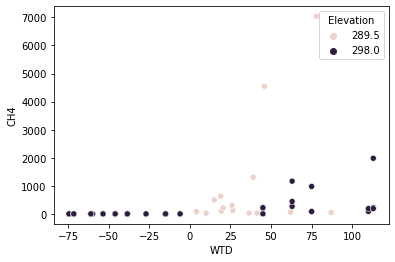

In [3]:
df = df1[['CH4','CH4_R2','WTD','Elevation']].dropna().reset_index(drop=True)
sns.scatterplot(x='WTD', y='CH4', hue='Elevation', data=df)

In [4]:
df_elev1 = df[df['Elevation'] == 289.5]
df_elev2 = df[df['Elevation'] == 298.0]
df_elev1

,CH4,CH4_R2,WTD,Elevation
4,495.484586,0.86,15.0,289.5
9,78.573794,0.98,4.0,289.5
10,98.758080,0.99,19.5,289.5
15,215.458905,0.99,20.5,289.5
16,118.791191,0.99,26.5,289.5
21,630.050525,1.00,19.0,289.5
22,26.188279,1.00,36.5,289.5
27,303.858985,0.99,26.0,289.5
28,27.815947,0.99,41.5,289.5
33,1304.706571,0.95,39.0,289.5


In [5]:
def plot_transects_CH4_nl(df, col_name):
    #nonlinear version 
    # if looking at different tree species, replace hue = 'Elevation' with the name of the species column

    from scipy.optimize import curve_fit

    # Define the weighting function - currently uses same weighting for all points, but this could be changed
    # e.g., if negative points are over accounted for
    def weight_function(depth):
        if depth >= -10:
            return 1.0  # Full weight for points with depth >= 0
        else:
            return 1.0 # Adjust this value to control the weight for points with depth < 0

    # Define the exponential model function
    def exponential_model(t, a, b, c):
        return a * np.exp(b * t) + c

    # Calculate the weights for each data point based on depth
    weights = [weight_function(depth) for depth in df['WTD'].values]

    # curve fit with weighted data - currently the weights are all 1.
    # values for the a, b, and c coefficients can be initialised within p0, this can help with convergence if there is an error, 
    # but shouldn't give different outputs
    p_opt, p_cov = curve_fit(exponential_model, df['WTD'].values, df[col_name].values, p0=(0, 0, 0), sigma=1/np.array(weights))
    
    
    # the fitted values a, b, c
    a, b, c = p_opt
    
    #Calculating the residuals
    residuals = df[col_name].values - exponential_model(df['WTD'].values, *p_opt)
    
    # sum of squares of the residuals
    ss_res = np.sum(residuals**2)
    
    # total sum of squares
    ss_tot = np.sum((df[col_name].values-np.mean(df[col_name]))**2)
    
    # R2 value
    r_squared = 1 - (ss_res / ss_tot)

    print ("CH4 = " + str(a) + 'exp(' + str(b) + 'WL)' + str(c)) 
    print ('R squared: ' + str(round(r_squared,3)))

    g = sns.lmplot(x="WTD", y=col_name, hue="Elevation", data=df, fit_reg=False,legend=False,palette='colorblind', height=7, aspect=2)     
    plt.legend()
    #g.set(xlim = (-10,-4.5))
    sns.set_style('ticks')
    
    x_fit = np.linspace(min(df['WTD'].values), max(df['WTD'].values), 100)

    # compute fitted y values
    y_fit = [exponential_model(x, a, b, c) for x in x_fit]
    
    # plotting the quadratic fit
    ax = g.axes[0,0]
    ax.plot(x_fit, y_fit, c="black", label="quadratic fit",linewidth=4)
    
    g.ax.axhline(0, ls='--',c='gray')
    CH4_0 = np.log(-c/a)/b
    g.ax.axvline(CH4_0, ls='--', c='gray')
    #db_at_zero = -intercept/slope
    print ('Water level for CH4=0: ' + str(round(CH4_0,1)) + ' cm')
    #g.ax.axvline(-intercept/slope, ls='--', c='gray')
    
    g.ax.set_title("$CH_4$ flux = " + str(round(a,2)) + '$e^{' +str(round(b,2)) + 'WL}$ - ' + str(round(np.abs(c),2)))
    g.ax.set_xlabel('Water level (cm)', fontsize = 14)
    g.ax.set_ylabel("CH4 flux (nmol $m^{-2}$ $s^{-1}$)", fontsize = 14)
    
    return(a,b,c,g)

CH4 = 675051.9371247273exp(8.32215345212107e-06WL)-674761.2620368295
R squared: 0.106
Water level for CH4=0: -51.8 cm


(675051.9371247273,
 8.32215345212107e-06,
 -674761.2620368295,
 <seaborn.axisgrid.FacetGrid at 0x7f4dcab36490>)

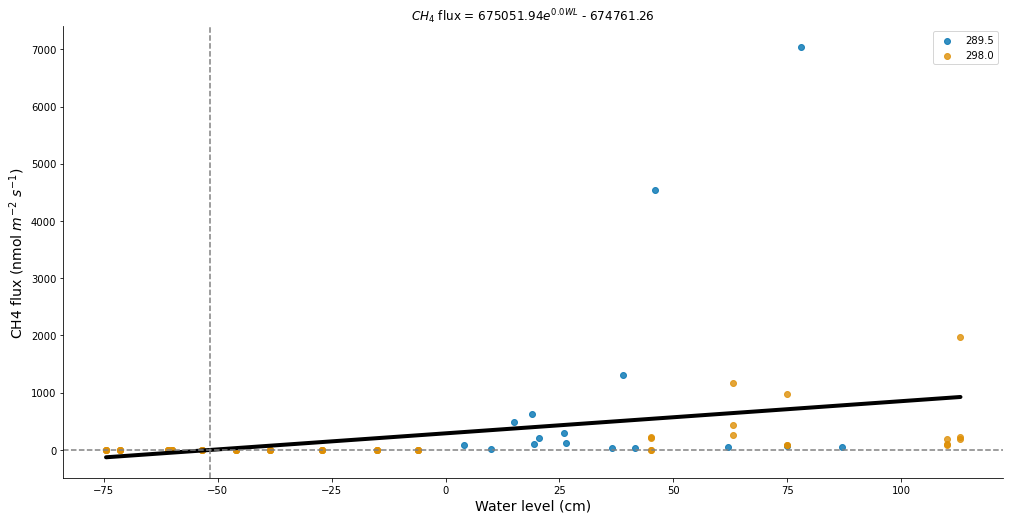

In [6]:
# ALL elevations
plot_transects_CH4_nl(df, 'CH4')

CH4 = 2345453.222722784exp(1.2664292375470385e-05WL)-2345634.9227575446
R squared: 0.148
Water level for CH4=0: 6.1 cm


(2345453.222722784,
 1.2664292375470385e-05,
 -2345634.9227575446,
 <seaborn.axisgrid.FacetGrid at 0x7f4dc29698b0>)

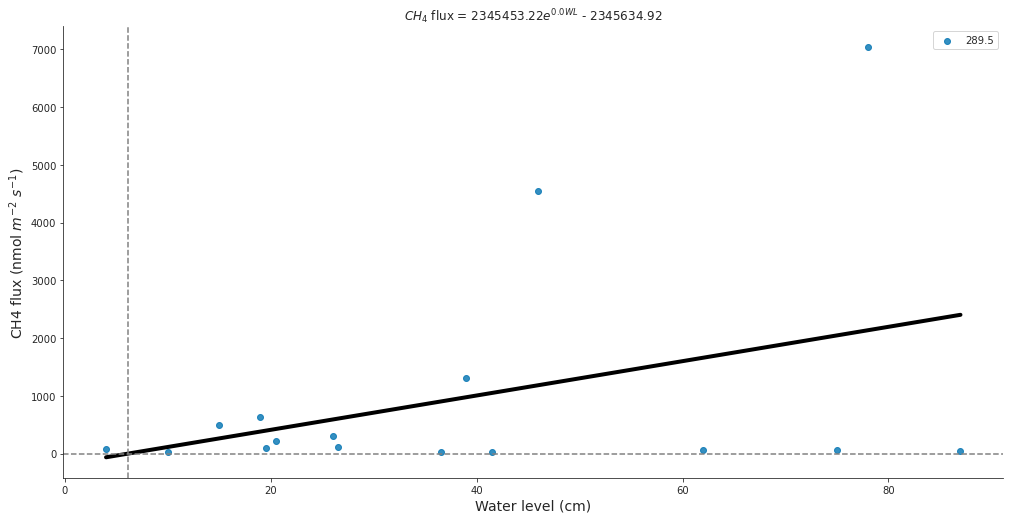

In [7]:
# elevation == 289.5 m
plot_transects_CH4_nl(df_elev1, 'CH4')

CH4 = 292.91011554904446exp(0.008081756481891965WL)-199.62736929599174
R squared: 0.297
Water level for CH4=0: -47.4 cm


(292.91011554904446,
 0.008081756481891965,
 -199.62736929599174,
 <seaborn.axisgrid.FacetGrid at 0x7f4dc2985e20>)

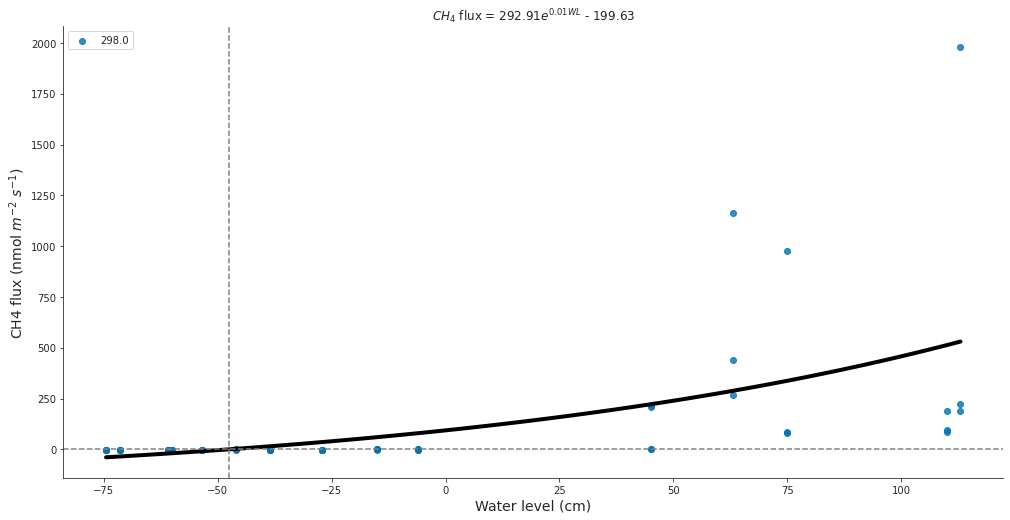

In [8]:
# elevation == 298.0 m -- a significant exponential relationship can be seen here
plot_transects_CH4_nl(df_elev2, 'CH4')